In [27]:
import numpy as np
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score,plot_precision_recall_curve,average_precision_score

## Some Early Processing of Metadata for Easier Model Training:

In [28]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df = all_xray_df.drop(['Unnamed: 11'],axis = 1)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
58074,00014366_001.png,No Finding,1,14366,63,M,PA,2990,2948,0.143,0.143,/data/images_007/images/00014366_001.png
92148,00023009_004.png,No Finding,4,23009,20,M,AP,3056,2544,0.139,0.139,/data/images_010/images/00023009_004.png
64865,00016012_002.png,Infiltration,2,16012,10,M,PA,2514,2991,0.143,0.143,/data/images_007/images/00016012_002.png


In [29]:
#Separating the labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df = all_xray_df.rename(columns={'Pneumonia':'pneumonia_class'})
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,pneumonia_class,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [31]:
# Function to split data
def create_splits(vargs,stratify):
## It's important to consider here how balanced or imbalanced we want each of those sets to be
## for the presence of pneumonia
  train_df, valid_df = sklearn.model_selection.train_test_split(vargs,test_size=0.2,stratify=vargs[stratify]) 

  return train_df, valid_df

In [32]:
train_df,valid_df = create_splits(all_xray_df,'pneumonia_class')

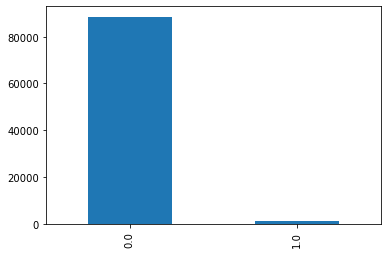

In [33]:
(train_df['pneumonia_class']).value_counts().plot(kind='bar')
plt.show()

#### We can see that the class is imbalanced. We want to have a balanced training set so that the model has an equal number of cases in each class to learn.

In [34]:
print('Positive Cases: ',sum(train_df['pneumonia_class']==1))
print('Negative Cases: ',sum(train_df['pneumonia_class']==0))



Positive Cases:  1145
Negative Cases:  88551


Positive Cases:  1145
Negative Cases:  1145


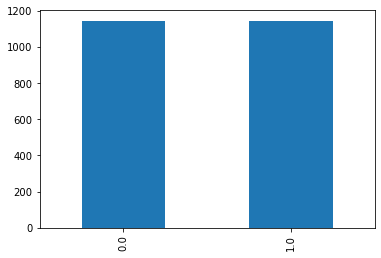

In [35]:
# Lets drop some negative classes to get balanced training dataset
d1 = train_df[train_df['pneumonia_class']==1]
d0 = train_df[train_df['pneumonia_class']==0].reset_index(drop=True).sample(len(d1))
train_df = pd.concat([d1,d0])

print('Positive Cases: ',sum(train_df['pneumonia_class']==1))
print('Negative Cases: ',sum(train_df['pneumonia_class']==0))

(train_df['pneumonia_class']).value_counts().plot(kind='bar')
plt.show()

#### The Ratio of Postive to Negative Class in Validation Dataset should be 1:4 or 1:5

In [36]:

d1 = valid_df[valid_df['pneumonia_class']==1]
d0 = valid_df[valid_df['pneumonia_class']==0].reset_index(drop=True).sample(4*len(d1))
valid_df = pd.concat([d1,d0])

print('Positive Cases: ',sum(valid_df['pneumonia_class']==1))
print('Negative Cases: ',sum(valid_df['pneumonia_class']==0))


Positive Cases:  286
Negative Cases:  1144


## Now We Can Begin Our Model-Building & Training

In [37]:
IMG_SIZE = (224, 224)
# Function to specify image augmentation parameters
def my_image_augmentation(data_type):
    if data_type == 'train':
        my_idg = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip = False,
                                    vertical_flip = False,
                                    shear_range = 0.1,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    height_shift_range = 0.1,
                                    width_shift_range = 0.1)
    elif data_type == 'valid':
        my_idg = ImageDataGenerator(rescale = 1./255) # Only rescaling for validation images

    return my_idg

# Function to make augmented data for training
def make_train_gen(df,size):
    my_train_idg = my_image_augmentation('train')
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'raw', 
                                          target_size = IMG_SIZE, 
                                          batch_size = size
                                          )


    return train_gen

# Function to make augmented data for testing
def make_val_gen(val_data,size):
    my_val_idg = my_image_augmentation('valid')
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'raw',
                                              target_size = IMG_SIZE, 
                                              batch_size = size) 
    

    return val_gen

In [38]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(valid_df,32)
valX, valY = val_gen.next()

Found 1430 validated image filenames.


## Looking At Some Examples of Our Augmented Training Data.

Found 2290 validated image filenames.


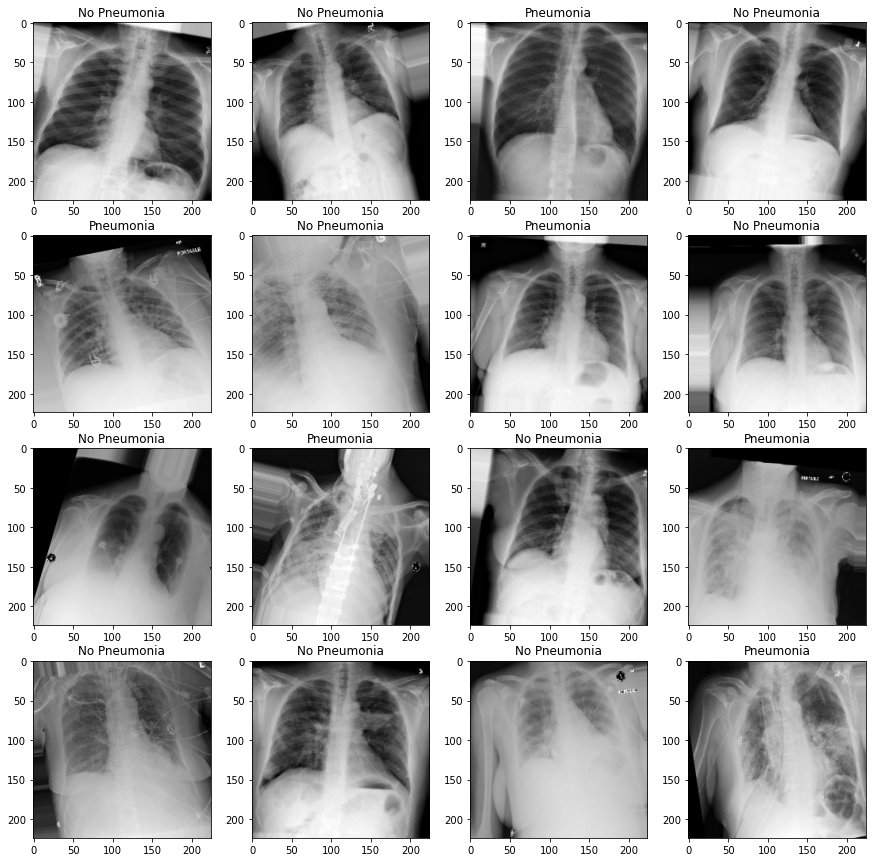

In [39]:
train_gen = make_train_gen(train_df,32)
t_x, t_y = next(train_gen)
fig,axs = plt.subplots(4,4,figsize = (15,15))
axs = axs.ravel()
for c_x,c_y,c_axs in zip(t_x,t_y,axs):
    c_axs.imshow(c_x[:,:,0],cmap='gray')
    if c_y == 1:
        c_axs.set_title('Pneumonia')
    else:
        c_axs.set_title('No Pneumonia')
    

## Build your model: 



In [40]:
def load_pretrained_model():
    
    model = VGG16(include_top = True,weights = 'imagenet') 
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    #vgg_model.summary()
    
    for layer in vgg_model.layers[0:17]: #Freezing all the layers except the last convolution layer
        layer.trainable = False
    
    
# for layer in model.layers: # Checking if correct layers are forzen
    #print(layer.name,layer.trainable)
    
    return vgg_model


In [41]:
vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 12s 0us/step


In [42]:
def build_my_model():
    
    vgg_model = load_pretrained_model()
    model = Sequential()
    model.add(vgg_model)
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(activation = 'sigmoid', units = 1))
    
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    
    return model



In [43]:
## Below code will allow to add checkpoints to our model,
## This will save the 'best' version of the model by comparing it to previous epochs of training

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [44]:
## train model
my_model = build_my_model()
my_model.summary()
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX,valY), 
                           epochs = 20, 
                           verbose = 1,      
                           callbacks = callbacks_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

##### After training for some time, looking at the performance of the model by plotting some performance statistics:



In [49]:
## After training, make some predictions to assess model's overall performance
val_gen = make_val_gen(valid_df,1430)
valX, valY = val_gen.next()
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)

Found 1430 validated image filenames.
1430/1430 [==============================] - 19s 13ms/step


In [82]:
# Fucntion to plot ROC Curve
def plot_auc(t_y, p_y):
    plt.figure(figsize=(5,5))
    fpr, tpr, thresholds = roc_curve(t_y,p_y)
    auc_ans = auc(fpr, tpr)
    plt.plot(fpr,tpr, label = ('AUC: %0.3f'%auc_ans),color='red',lw=2)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    pass
    

# Function to calculate precision, recall and threshold and plot precision recall curve
def plot_precision_recall_curve(t_y, p_y):
    plt.figure(figsize=(5,5))
    precision, recall,threshold = precision_recall_curve(t_y,p_y)
    ap = average_precision_score(t_y,p_y)
    plt.plot(recall,precision,label=('AP: %0.3f'%ap))
    plt.title('precision recall curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend()
    plt.show()
    return precision,recall,threshold

# Function to calculate the F1 score
def calc_f1(prec,recall):
    f1 = 2*(prec*recall)/(prec+recall)
    return f1

# Function to plot loss and accuracy history
def plot_history(history):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    pass

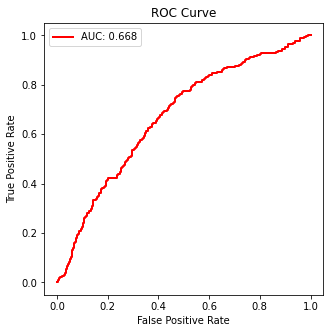

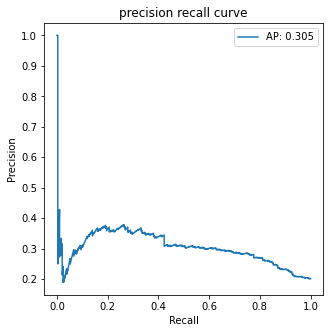

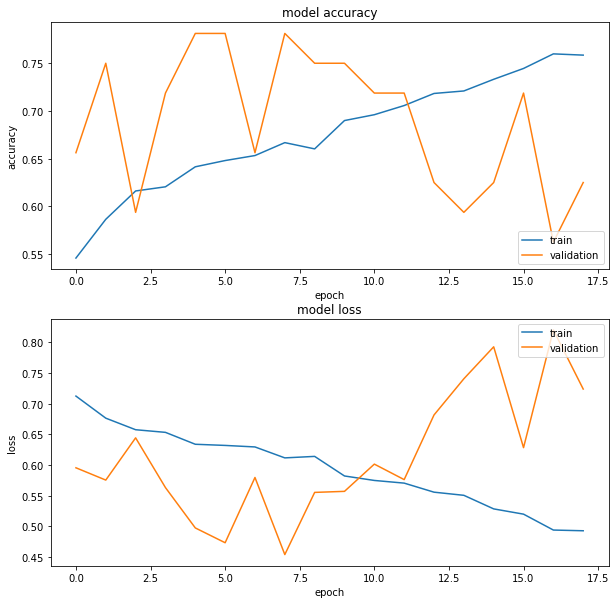

In [83]:
## plot figures
plot_auc(valY,pred_Y)

precision,recall,threshold= plot_precision_recall_curve(valY,pred_Y)

plot_history(history)



##### We can see that the model is penalized for predicting the majority class in all cases. The scores show that the model that looked good according to the ROC Curve is in fact barely skillful when considered using using precision and recall that focus on the positive class.

##### This is possible because the model predicts probabilities and is uncertain about some cases. These get exposed through the different thresholds evaluated in the construction of the curve, flipping some class 0 to class 1, offering some precision but very low recall.

#### Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [66]:
## Find the threshold that optimizes model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
f1 = calc_f1(precision,recall)
metrics_df = pd.DataFrame({'Precision':precision[:-1],'Recall':recall[:-1],'Threshold':threshold,'F1':f1[:-1]})
metrics_df

,Precision,Recall,Threshold,F1
0,0.201408,1.000000,0.059868,0.335287
1,0.200846,0.996503,0.060741,0.334311
2,0.200987,0.996503,0.064032,0.334507
3,0.201129,0.996503,0.065012,0.334703
4,0.201271,0.996503,0.067940,0.334900
...,...,...,...,...
1415,0.400000,0.006993,0.842836,0.013746
1416,0.250000,0.003497,0.854598,0.006897
1417,0.333333,0.003497,0.862685,0.006920
1418,0.500000,0.003497,0.866168,0.006944


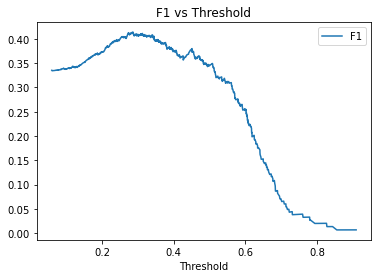

In [72]:
metrics_df.plot(x ='Threshold', y='F1', kind = 'line')
plt.title('F1 vs Threshold')
plt.show()

In [70]:
print('Maximum f1:', metrics_df['F1'].max())
threshold = metrics_df.iloc[metrics_df['F1'].idxmax()]['Threshold']
print('Threshold:', threshold)

Maximum f1: 0.41352657004830917
Threshold: 0.28675130009651184


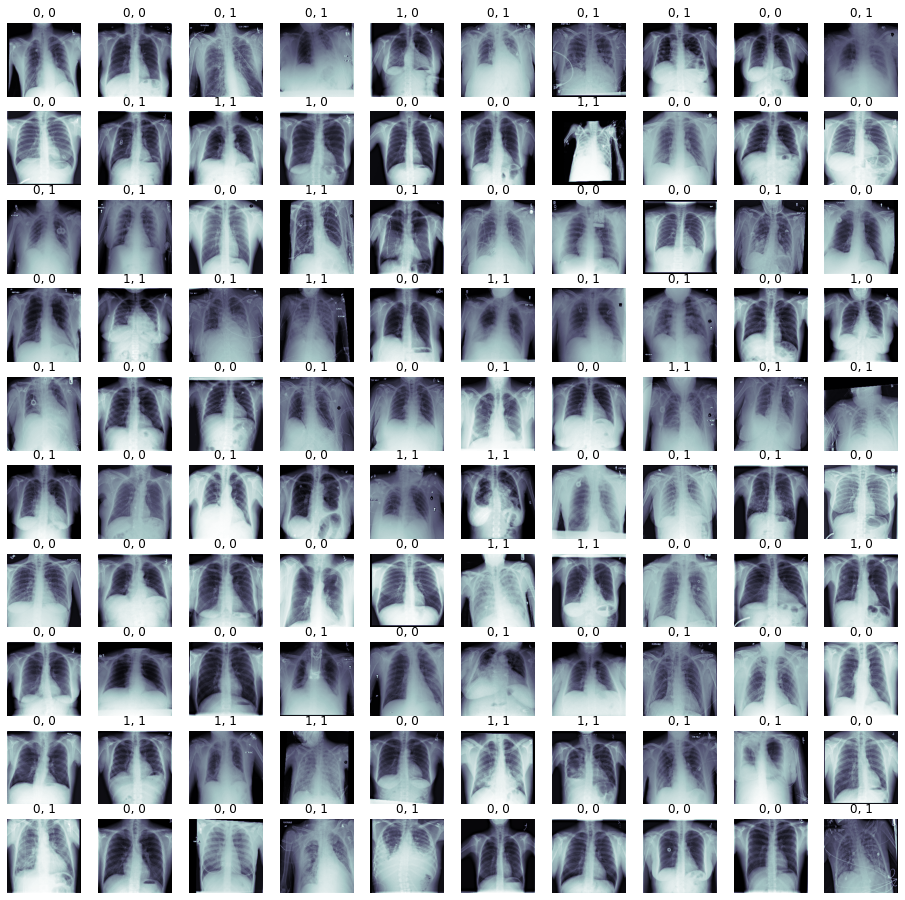

In [78]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > threshold:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > threshold: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [84]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)